# **Aprendizaje Automático para Machine Learning**

## Actividad individual 5: "GENERACIÓN DE TEXTO"

Fabio Santamaría Iglesias

27/07/2021

# Generación de texto con una red LSTM
En esta actividad vamos a utilizar una red recurrente LSTM para generar texto.

El corpus que sirve de referencia para generar los textos se compone de obras de H.P. Lovecraft, aunque se puede utilizar cualquier otro.

El interés de esta actividad es utilizar las redes **LSTM para algo distinto de una clasificación**, aunque, como se puede observar, la calidad de los textos generados es inferior a la que se consigue con otros modelos más actuales, como los transformer.

**Debes completar el código en las secciones indicadas con # COMPLETAR CODIGO**

## Instalación e importación de paquetes

In [ ]:
!pip install progressbar2

In [ ]:
import os
import urllib
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import html

import nltk
from nltk import word_tokenize
nltk.download('punkt')
import pickle
import random
import progressbar
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical

try:
    from nltk.tokenize.moses import MosesDetokenizer
    detokenizer = MosesDetokenizer()
    use_moses_detokenizer = True
except:
    use_moses_detokenizer = False

print(f"use_moses_detokenizer={use_moses_detokenizer}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
use_moses_detokenizer=False


## Definición de parámetros del corpus y su preprocesado

In [ ]:
#Ya no esta disponible
#corpus_url = "https://archive.org/stream/TheCollectedWorksOfH.p.Lovecraft/The-Collected-Works-of-HP-Lovecraft_djvu.txt"
corpus_path = "lovecraft.txt"

preprocessed_corpus_path = "lovecraft_preprocessed.p"
most_common_words_number = 10000


## Tranformación entre palabras e índices
Se definen dos funciones:
* **encode_sequence**: codifica una secuencia de palabras en una secuencia de índices
* **decode_indices**: decodifica una secuencia de índices en la secuencia de palabras correspondiente

In [ ]:
def encode_sequence(sequence, vocabulary):

    return [vocabulary.index(element) for element in sequence if element in vocabulary]


def decode_indices(indices, vocabulary):

    decoded_tokens = [vocabulary[index] for index in indices]
    if use_moses_detokenizer  == True:
        return detokenizer.detokenize(decoded_tokens, return_str=True)
    else:
        return " ".join(decoded_tokens)

## Descarga del corpus
Solo se descarga si no se encuentra en local (Colab o disco)

In [ ]:
!rm lovecraft.txt
!wget https://github.com/albertojulian/master-ub/raw/main/lovecraft.txt
!ls -al lovecraft.txt

preprocess_anyway = True

--2021-07-26 16:05:35--  https://github.com/albertojulian/master-ub/raw/main/lovecraft.txt
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/albertojulian/master-ub/main/lovecraft.txt [following]
--2021-07-26 16:05:35--  https://raw.githubusercontent.com/albertojulian/master-ub/main/lovecraft.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3666684 (3.5M) [text/plain]
Saving to: ‘lovecraft.txt’

lovecraft.txt       100%[===================>]   3.50M  20.8MB/s    in 0.2s    

2021-07-26 16:05:36 (20.8 MB/s) - ‘lovecraft.txt’ saved [3666684/3666684]

-rw-r--r-- 1 root root 3666684 Jul 26 16:05 lo

## Preprocesado del corpus
Solo se preprocesa si no se ha hecho antes.

In [ ]:
def preprocess_corpus_if_necessary():

    if not os.path.exists(preprocessed_corpus_path) or preprocess_anyway:
        print("Preprocesamos el corpus...")

        corpus_file = open(corpus_path, "r")
        corpus_string = corpus_file.read()

        # Generación del vocabulario
        print("Extraemos las palabras (tokens)...")
        corpus_tokens = word_tokenize(corpus_string)
        print("Número de tokens:", len(corpus_tokens))
        print("Generamos el vocabulario...")
        word_counter = Counter()
        word_counter.update(corpus_tokens)
        print("Longitud del vocabulario antes del corte:", len(word_counter))
        vocabulary = [key for key, value in word_counter.most_common(most_common_words_number)]
        print("Longitud del vocabulario después del corte:", len(vocabulary))

        # Conversión a índices
        print("Codificamos a índices...")
        indices = encode_sequence(corpus_tokens, vocabulary)
        print("Número de índices:", len(indices))

        # Saving.
        print("Grabamos fichero de preprocesado del corpus...")
        pickle.dump((indices, vocabulary), open(preprocessed_corpus_path, "wb"))
    else:
        print("El corpus ya estaba preprocesado")

preprocess_corpus_if_necessary()

Preprocesamos el corpus...
Extraemos las palabras (tokens)...
Número de tokens: 703845
Generamos el vocabulario...
Longitud del vocabulario antes del corte: 35697
Longitud del vocabulario después del corte: 10000
Codificamos a índices...
Número de índices: 662558
Grabamos fichero de preprocesado del corpus...


## Generación del dataset
Enfocamos la generación del dataset como un **aprendizaje auto-supervisado (self-supervised learning)**:
* para generar secuencias de entrada, seleccionamos de forma aleatoria una secuencia de índices (correspondientes a palabras) del corpus
* para asignar una etiqueta, escogemos el índice de la palabra siguiente a la secuencia de entrada

In [ ]:
# Parámetros de generación del dataset
dataset_size = 50000
sequence_length = 30 # longitud de los textos del dataset de entrenamiento

def get_dataset(indices):

    data_input = []
    data_output = []
    current_size = 0
    bar = progressbar.ProgressBar(max_value=dataset_size)
    while current_size < dataset_size:

        # seleccionamos de forma aleatoria una secuencia de índices (correspondientes a palabras)
        random_index = random.randint(0, len(indices) - (sequence_length + 1))
        input_sequence = indices[random_index:random_index + sequence_length]
        # la etiqueta de la secuencia aleatoria es el índice de la siguiente palabra
        output_label = indices[random_index + sequence_length]

        data_input.append(input_sequence)
        data_output.append(output_label)

        current_size += 1
        bar.update(current_size)
    bar.finish()

    # Transformamos las listas a numpy arrays
    data_input = np.array(data_input)
    data_output = np.array(data_output)
    return (data_input, data_output)


## Definición de la red LSTM y entrenamiento


La Long Short-Term Memory (LSTM) es una arquitectura de red neuronal recurrente (RNN) utilizada en el campo del aprendizaje profundo (Deep Learning). A diferencia de las redes neuronales de prealimentación (feedforward neural networks) estándar, las LSTM tienen conexiones de retroalimentación (feedback connections). Esto les permite no solo procesar puntos de datos individuales (como imágenes), sino también secuencias completas de datos (como voz o vídeo). Por ejemplo, las LSTM son aplicables a tareas como el reconocimiento de escritura a mano conectada y no segmentada, reconocimiento de voz y detección de anomalías en el tráfico de red o IDS (sistemas de detección de intrusos). 

Las LSTM modificaron la arquitectura original de las RNN para mejorar la capacidad de la red neuronal "de recordar" y así poder trabajar con secuencias de dependencias más largas, como las que pueda haber en un texto. Son adecuadas para clasificar, procesar y hacer predicciones basadas en datos de series de tiempo, ya que puede haber retrasos de duración desconocida entre eventos importantes en una serie de tiempo. Se desarrollaron para hacer frente al problema de anulación del gradiente (vanishing gradient problem) que se puede encontrar al entrenar a las RNN tradicionales. 








La arquitectura básica de una red recurrente se dispone de la siguiente manera:

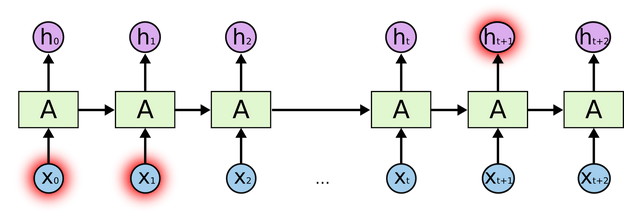


Donde la caja A es la red en su totalidad, que se representa repetida de izquierda a derecha en diferentes momentos temporales. $x_t$ y $h_t$ son  respectivamente los inputs y las predicciones (en modelos de una sola capa) del modelo para un tiempo $t$.
Como vemos en la imagen, el estado oculto viaja de izquierda a derecha, convirtiéndose en una entrada y salida del modelo, pasando la información del estado inmediatamente anterior al sigiuente.


La particularidad de las LSTM reside en usar un modelo mucho más complejo y que contiene un estado oculto:

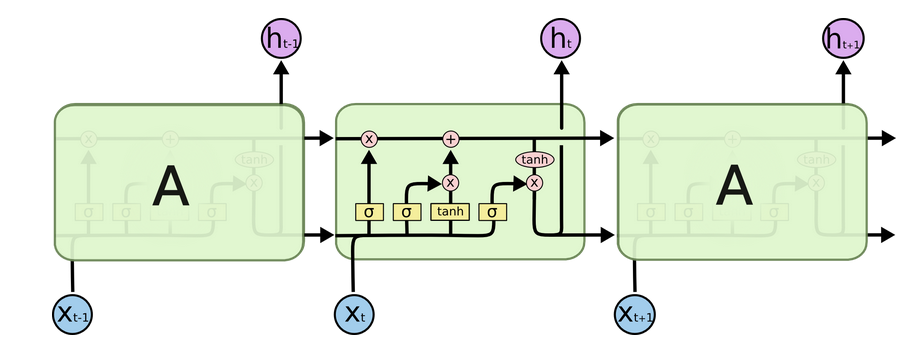

Fuente de la imagen: [colah.github.io](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

Una unidad LSTM común se compone de una celda, en la que hay una puerta de entrada (input gate), una puerta de salida (output gate) y una puerta de olvido (forget gate). La celda recuerda valores en intervalos de tiempo arbitrarios y las tres puertas regulan el flujo de información dentro y fuera de la celda.

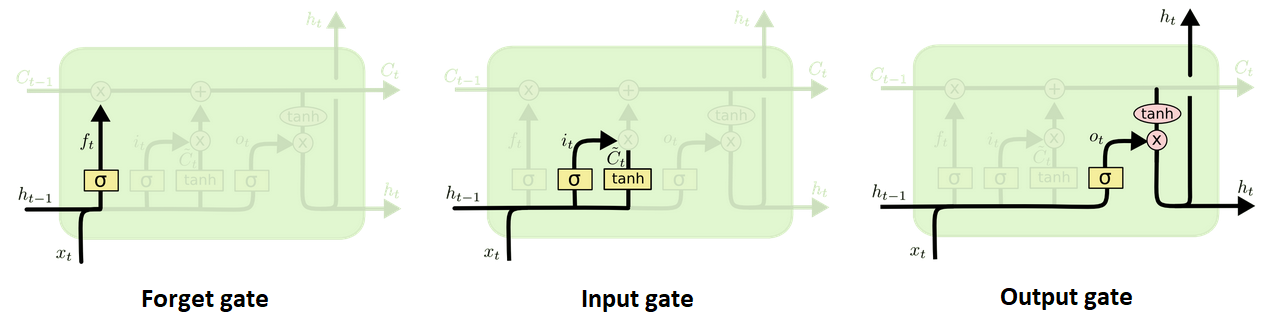

Fuente de la imagen: [colah.github.io](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

Más en detalle, como podemos ver en la figura, las tres puertas interactúan con una entrada $C(i-1)$ que cruza por la parte vertical de lado a lado. Esta es conocida como la *cell state*, y básicamente es como una cinta transportadora que lleva la información a lo largo de la red LSTM, cruzando toda su cascada de bloques.
Las tres puertas, haciendo uso de sus activaciones sigmoides y tangenciales, y en combinación con los pesos que se incluyen en cada una, permiten determinar la salida $h(i)$ de cada bloque de la LSTM de modo que la información importante para ese punto $i$ de la secuencia haya sido seleccionada. Gracias al uso de $C$ y las tres puertas, el cálculo del gradiente se simplifica incluso entre puntos alejados.

Creamos la función *train_neural_network*, la cual solo se define y solo entrena si no se ha hecho con anterioridad o si se fuerza con el parámetro *train_anyway*. Por último, se graba el modelo y se representa la evolución de las métricas definidas en función del número de iteraciones.

N/A% (0 of 50000) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--


Generamos el dataset...


100% (50000 of 50000) |##################| Elapsed Time: 0:00:00 Time:  0:00:00


Creamos el modelo...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 1000)          10000000  
_________________________________________________________________
lstm (LSTM)                  (None, 1000)              8004000   
_________________________________________________________________
dense (Dense)                (None, 10000)             10010000  
_________________________________________________________________
activation (Activation)      (None, 10000)             0         
Total params: 28,014,000
Trainable params: 28,014,000
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 1000)          10000000  
___

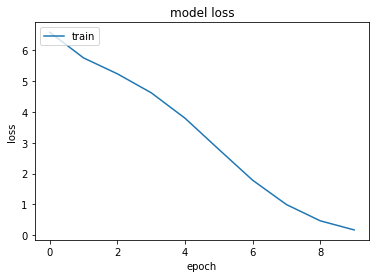

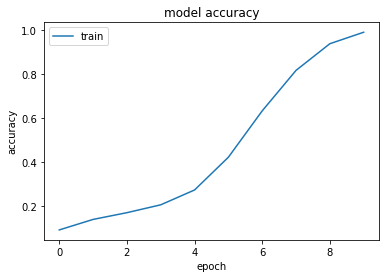

In [ ]:
# Parámetros del modelo y entrenamiento
train_anyway = True # fuerza el entrenamiento, aunque se haya realizado antes
epochs = 10 # número de interaciones a entrenar
batch_size = 128 # tamaño de lote
hidden_size = 1000 # número de nodos en la red LSTM
model_path = "lovecraft_model.h5"

def train_neural_network():

    if not os.path.exists(model_path) or train_anyway == True:

        # Carga de las palabras del corpus y sus índices
        indices, vocabulary = pickle.load(open(preprocessed_corpus_path, "rb"))

        # Generación del dataset
        print("\nGeneramos el dataset...")
        data_input, data_output = get_dataset(indices)
        data_output = to_categorical(data_output, num_classes=len(vocabulary))

        # Creación del modelo
        print("Creamos el modelo...")
        # COMPLETAR CODIGO (debes seguir las indicaciones de la actividad para generar la red LSTM)
        model = models.Sequential() 
        model.add(layers.Embedding(len(vocabulary), hidden_size, input_length=sequence_length))
        model.add(layers.LSTM(hidden_size))
        model.add(layers.Dense(len(vocabulary)))
        model.add(layers.Activation('softmax'))
        model.summary()
        model.summary()

        # Definimos el resto del modelo: optimizador, función de pérdidas y métrica
        # COMPLETAR CODIGO
        model.compile(
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )

        # Entrenamiento del modelo
        print("Entrenamos el modelo...")
        # COMPLETAR CODIGO
        history = model.fit(
            data_input, data_output,
            epochs=epochs, batch_size=batch_size)
        
        # Grabación del modelo
        print("...y grabamos el modelo")
        model.save(model_path)

        plot_history(history)

        return history

def plot_history(history):

    print(history.history.keys())

    # Gráfica de función de pérdida
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.savefig("history_loss.png")
    # plt.clf()
    plt.show()
    plt.close()
    
    # Gráfica de accuracy.
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.savefig("history_accuracy.png")
    # plt.clf()

    plt.show()
    plt.close()
        
history = train_neural_network()

Como podemos comprobar, la función de coste desciende monótonamente conforme aumentan las iteraciones en el conjunto de entrenamiento. Con respecto a la *accuracy*, va subiendo pasando de cerca del 0 a casi el 100% en menos de 10 iteraciones.



In [ ]:
print(np.max(history.history['accuracy']))

0.9901400208473206


De estos dos resultados puede concluirse que el aprendizaje fundamental se realiza en las primeras iteraciones. Más allá, el modelo está memorizando los textos de entrenamiento muy bien y está siendo capaz de predecir palabras casi a la perfección.

Hay que tener en cuenta que no tiene sentido penalizar nuestro modelo por usar palabras diferentes a las correctas siempre y cuando el texto generado tenga sentido. Es por ello que la accuracy sobre un conjunto de validación es una métrica que nos indica poco o nada con respecto a la utilidad a la hora de generar palabras.

## Generación de texto

La generación de texto se basa en la función **get_index_from_prediction**, que obtiene un índice (asociado a una palabra) a partir de una predicción y un parámetro de temperatura. 

En concreto, la función *predict* del modelo devuelve una lista con las probabilidades de todas las palabras posibles, en este caso 10.000 predicciones. A continuación, estas predicciones se introducen en la función *get_index_from_prediction*. De aquí, podemos diferenciar dos comportamientos según el parámetro temperatura, $T$:

* Si $T = 0$: entonces se escoge como predicción aquella cuya probabilidad es la más alta.

* Si $T > 0$: se aplica una serie de transformaciones sobre la lista de probabilidades. Lo más importante es que el valor de la temperatura aparece dividiendo dentro de la exponenciación de las probabilidades. 

  $$\exp^{ P_\text{prediction prob list} / T}$$

  De esta forma, una temperatura muy pequeña dará relevancia solo a palabras con una muy alta probabilidad. Por el contrario, una temperatura alta hará que las diferencias entre las probabilidades se suavicen. Finalmente, se escoge un valor aleatorio de esta lista usando una distribución multinomial creada a partir de estas nuevas probabilidades. Así, con una temperatura alta se espera obtener textos más variados, evitando posibles repeticiones.

El primer paso es cargar el corpus y escoger de él una muestra a modo de secuencia semilla a partir de la cual se generarán los textos. De esta forma, como previamente habíamos definido *sequence_length = 30*, cogemos 30 palabras del corpus y realizamos la predicción de la palabra consecutiva a esta secuencia usando las funciones *predict* y *get_index_from_prediction* siguiendo el procedimiento explicado anteriormente. Repetimos hasta generar una frase de no más de 50 palabras (generated_sequence_length = 50) y pintamos esta por pantalla.

A continuación, generemos unos ejemplos con diferentes temperaturas:

In [ ]:
# Parámetros de generación de texto
generated_sequence_length = 50 # longitud de los textos generados
n_generated_texts = 15 # número de textos a generar

def generate_texts(n_generated_texts=10):

    print(f"Generamos {n_generated_texts} textos...")

    # carga del corpus
    indices, vocabulary = pickle.load(open(preprocessed_corpus_path, "rb"))

    # carga del modelo previamente grabado
    model = models.load_model(model_path)

    # Generamos tantos textos como indique el parámetro n_generated_texts
    for _ in range(n_generated_texts):

        # Escogemos un parámetro aleatorio "temperature" para la predicción
        temperature = random.uniform(0.0, 1.0)
        print("Temperatura:", temperature)

        # Obtenemos una muestra aleatoria a modo de secuencia semilla a partir de la cual se generarán textos
        random_index = random.randint(0, len(indices) - (generated_sequence_length))
        input_sequence = indices[random_index:random_index + sequence_length]

        # Generamos la secuenca de salida repitiendo la predicción
        generated_sequence = []
        while len(generated_sequence) < generated_sequence_length:
            prediction = model.predict(np.expand_dims(input_sequence, axis=0))
            predicted_index = get_index_from_prediction(prediction[0], temperature)
            generated_sequence.append(predicted_index)
            input_sequence = input_sequence[1:]
            input_sequence.append(predicted_index)

        # Convertimos la secuencia de índices generada en una frase
        text = decode_indices(generated_sequence, vocabulary)
        print(text)
        print("")

        
def get_index_from_prediction(prediction, temperature=0.0):

    # Temperatura cero - usamos argmax.
    if temperature == 0.0:
        return np.argmax(prediction)

    # Temperatura distinta de cero - aplicamos cierta aleatoriedad
    else:
        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction) / temperature
        exp_prediction= np.exp(prediction)
        prediction = exp_prediction / np.sum(exp_prediction)
        probabilities = np.random.multinomial(1, prediction, 1)
        return np.argmax(probabilities)


generate_texts(n_generated_texts)

Generamos 15 textos...
Temperatura: 0.7218627362873385
with a single shock , brick , and which a curious intensity . But in the of the Carter 's hemisphere , in another and then that Curwen was the right of these and in their earth 's nature - being who left out of this and more of the

Temperatura: 0.7799873740610341
vaster I 'd up nothing to see back . On the contrary in Olney into this object now in this who who have together as even I do n't drop prepared for anything ; and had so that it had been well before it . He paused , because of

Temperatura: 0.4223606140844657
. The instincts of Ulthar , all , or rifts some of the poet a of the strange , , and , , , , , , , , , and , , , , , , , , , , and , , , , , , , ,

Temperatura: 0.04709177743566384
of our own , and even madness shocking in a very very ancient way to keep the fresh way to the lawn ; and being almost solely in some of the scattered of the age and had been learned so many . In this , he could not no one

Temperatura: 0.

Si nos fijamos, hay palabras o signos de puntación repetidos. En particular, llama la atención la tercera frase, donde se repiten mucho las comas pese a tener una temperatura media de 0.42. Otro ejemplo de repetición sin sentido ocurre en el ejemplo noveno, donde de forma sucesiva aparece ' an '. Este último comportamiento es más esperable porque la temperatura es relativamente baja y esperamos menos variaciones.

Como punto positivo sí observamos que hay estructuras gramaticales aisladas que están bien construidas. Algunos ejemplos son: 

* pronombre personal (I, you, he, she, ...) seguido de verbo bien conjugado. "I asked", "had it been" ...

* en general, todo lo que puede preceder a un nombre: un adjetivo, "the old day"; un artículo, "a chair"; determinantes demostrativos, "this object"; determinantes posesivos: "his power"; etc

* destacan los adverbios de modo perfectamente colocados. "I had previously entered", "the old seemed to be friendly".

* el complemento directo seguido de un verbo: "There was a harmless note of his flight"

Como vemos, ha aprendido a mantener cierta estructura gramatical. No obstante, es muy fácil encontrar errores semánticos, más relativos al significado del texto. Por ejemplo, la frase:

*"There was a harmless note of his flight **who** had been enough to keep them at their last delirium".*

Aquí vemos que la *note* de la que se habla se trata como si fuese una persona. El resto de la frase está bien construida gramaticalmente, aunque no tiene mucho sentido.

Por último, no vemos que la temperatura tenga un impacto significativo en el sentido de la frase

*Temperatura: 0.7218627362873385*

*"with a single shock , brick , and which a curious intensity . But in the of the Carter 's hemisphere , in another and then that Curwen was the right of these and in their earth 's nature - being who left out of this and more of the"*


*Temperatura: 0.04709177743566384*

*"of our own , and even madness shocking in a very very ancient way to keep the fresh way to the lawn ; and being almost solely in some of the scattered of the age and had been learned so many . In this , he could not no one"*

En ambos ejemplos, apenas se vislumbra un atisbo de coherencia.




# Conclusiones:

Si descargamos el texto original podemos ver que está bien escrito. Las ideas están bien divididas en párrafos y están conectados correctamente, al igual que las frases. Por supuesto, la estructura gramatical es correcta y las palabras están bien escritas. El estilo es muy formal con palabras arcaicas. 

Sin embargo, en nuestro texto generado observamos que las frases no tienen sentido. No comienzan y desarrollan una idea. Además, observamos repeticiones de signos de puntuación y palabras. Por otro lado, a menudo nos encontramos con palabras que tienen un significado inadecuado con respecto a su contexto. Lo único que sí se respeta en general son las estructuras gramaticales básicas, cómo ordenar sintácticamente las palabras dentro de una frase.

No se han observado cambios significativos variando la temperatura. Esperábamos que a T baja el texto fuese más consistente y más parecido al texto de entrenamiento y que T alta hubiese más variaciones. No obstante, en general, se observa una falta de coherencia semántica en ambos regímenes.

Por todo esto, nuestro generador de texto no es una buena herramienta para generar novelas, ya que, a pesar de que escribe correctamente, no es capaz de crear un texto con significado completo o con ideas coherentes. Para tratar de mejorarlo, podríamos usar un modelo con más parámetros (comparado con GPT-2 nuestro modelo es muy simple), aumentar el número de capas LSTM y dense, así como el uso de técnicas como el *dropout*. Esto, sin embargo, requiere muchos recursos de entrenamiento que no son fácilmente accesibles hoy en día. 